In [1]:
device = 'mps'


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt


In [3]:
train_dataset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)

print(f"Training with {len(train_dataset)} samples")
print(f"Testing with {len(test_dataset)} samples")


Files already downloaded and verified
Files already downloaded and verified
Training with 50000 samples
Testing with 10000 samples


In [47]:
model = nn.Sequential(
    nn.BatchNorm2d(3),
    nn.Conv2d(3, 16, 4, stride=2, padding=1, bias=False), # (3, 32, 32) -> (16, 16, 16)
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.Conv2d(16, 32, 4, stride=2, padding=1, bias=False), # (16, 16, 16) -> (32, 8, 8)
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, 4, stride=2, padding=1, bias=False), # (32, 8, 8) -> (64, 4, 4)
    nn.ReLU(),
    nn.Flatten(),
    nn.BatchNorm1d(64*4*4),
    nn.Linear(64*4*4, 256, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, 10),
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

stats = {
    'train_loss': [],
    'test_loss': [],
    'test_accuracy': [],
}


In [48]:
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
print(model)


Model has 309,104 parameters
Sequential(
  (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (2): ReLU()
  (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (8): ReLU()
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Linear(in_features=1024, out_features=256, bias=False)
  (12): ReLU()
  (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Linear(in_features=256, out_features=10, bias=True)
)


In [49]:
for epoch in range(10):
    model.train()
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        # x = x.view(x.size(0), -1)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        stats['train_loss'].append(loss.item())
        
    print(f"Epoch {epoch} train loss {stats['train_loss'][-1]:.4f}")

    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            # x = x.view(x.size(0), -1)
            y_hat = model(x)
            test_loss += criterion(y_hat, y).item()
            correct += y.eq(y_hat.argmax(dim=1)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_accuracy = correct / len(test_loader.dataset)
        stats['test_loss'].append(test_loss)
        stats['test_accuracy'].append(test_accuracy)
        print(f"Epoch {epoch} test loss {test_loss:.4f} accuracy {test_accuracy*100:.2f}")


Epoch 0 train loss 1.6480
Epoch 0 test loss 0.0308 accuracy 35.91
Epoch 1 train loss 1.4935
Epoch 1 test loss 0.0184 accuracy 58.17
Epoch 2 train loss 1.2598
Epoch 2 test loss 0.0156 accuracy 65.11
Epoch 3 train loss 1.0895
Epoch 3 test loss 0.0143 accuracy 67.98
Epoch 4 train loss 0.4847
Epoch 4 test loss 0.0142 accuracy 69.04
Epoch 5 train loss 1.4154
Epoch 5 test loss 0.0158 accuracy 66.44
Epoch 6 train loss 1.1412
Epoch 6 test loss 0.0152 accuracy 68.41
Epoch 7 train loss 0.9050
Epoch 7 test loss 0.0162 accuracy 68.34
Epoch 8 train loss 0.9843
Epoch 8 test loss 0.0170 accuracy 67.76
Epoch 9 train loss 1.6090
Epoch 9 test loss 0.0198 accuracy 64.95


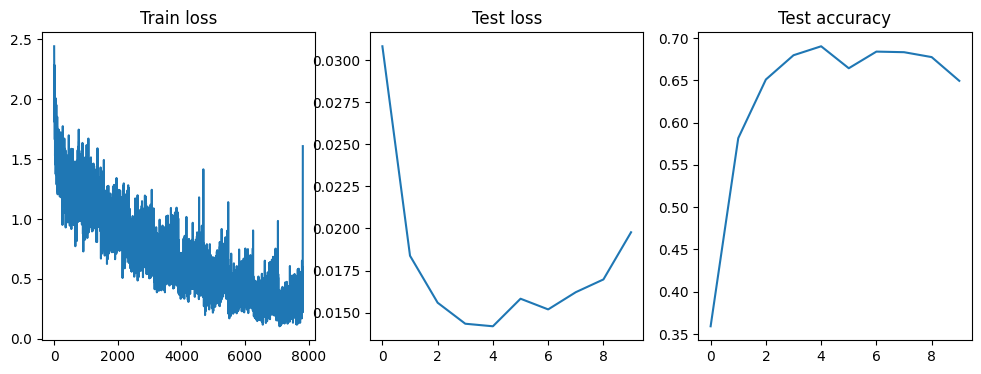

In [50]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(stats['train_loss'])
plt.title('Train loss')

plt.subplot(1, 3, 2)
plt.plot(stats['test_loss'])
plt.title('Test loss')

plt.subplot(1, 3, 3)
plt.plot(stats['test_accuracy'])
plt.title('Test accuracy')

plt.show()


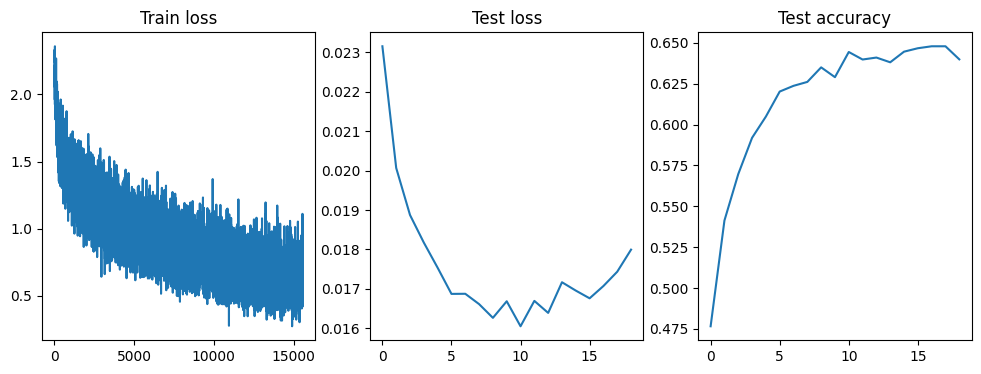

In [46]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(stats['train_loss'])
plt.title('Train loss')

plt.subplot(1, 3, 2)
plt.plot(stats['test_loss'])
plt.title('Test loss')

plt.subplot(1, 3, 3)
plt.plot(stats['test_accuracy'])
plt.title('Test accuracy')

plt.show()


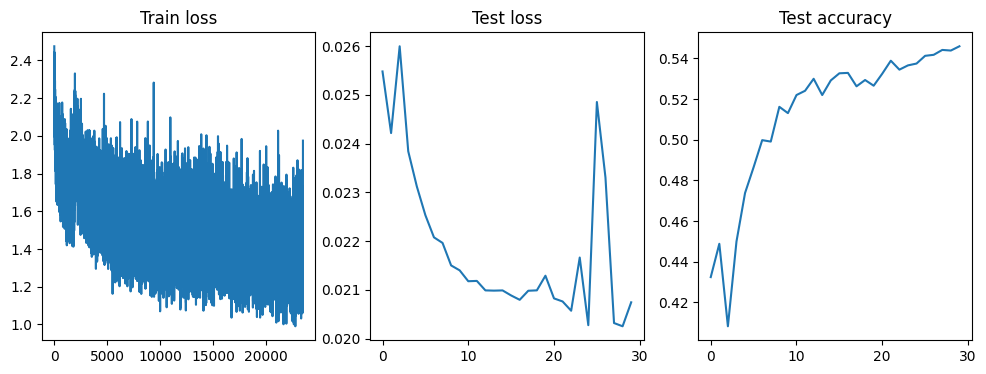

In [39]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(stats['train_loss'])
plt.title('Train loss')

plt.subplot(1, 3, 2)
plt.plot(stats['test_loss'])
plt.title('Test loss')

plt.subplot(1, 3, 3)
plt.plot(stats['test_accuracy'])
plt.title('Test accuracy')

plt.show()


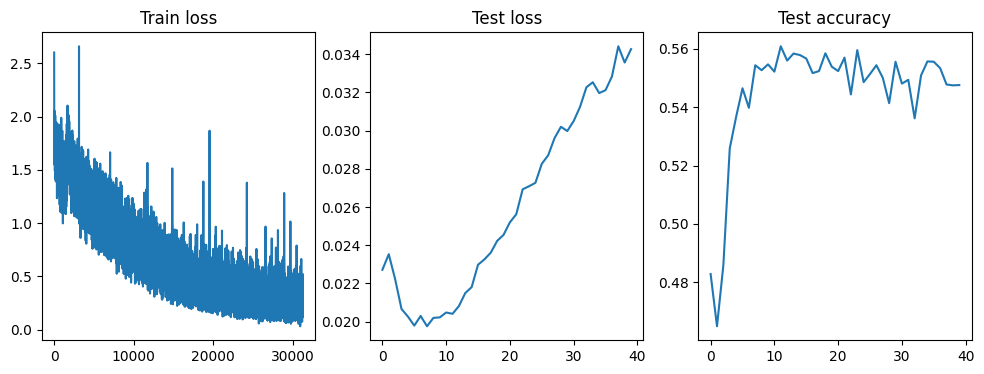

In [31]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(stats['train_loss'])
plt.title('Train loss')

plt.subplot(1, 3, 2)
plt.plot(stats['test_loss'])
plt.title('Test loss')

plt.subplot(1, 3, 3)
plt.plot(stats['test_accuracy'])
plt.title('Test accuracy')

plt.show()


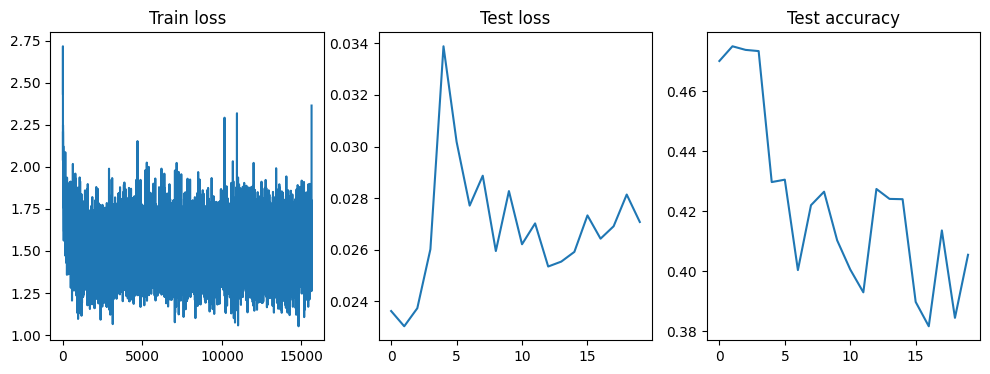

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(stats['train_loss'])
plt.title('Train loss')

plt.subplot(1, 3, 2)
plt.plot(stats['test_loss'])
plt.title('Test loss')

plt.subplot(1, 3, 3)
plt.plot(stats['test_accuracy'])
plt.title('Test accuracy')

plt.show()


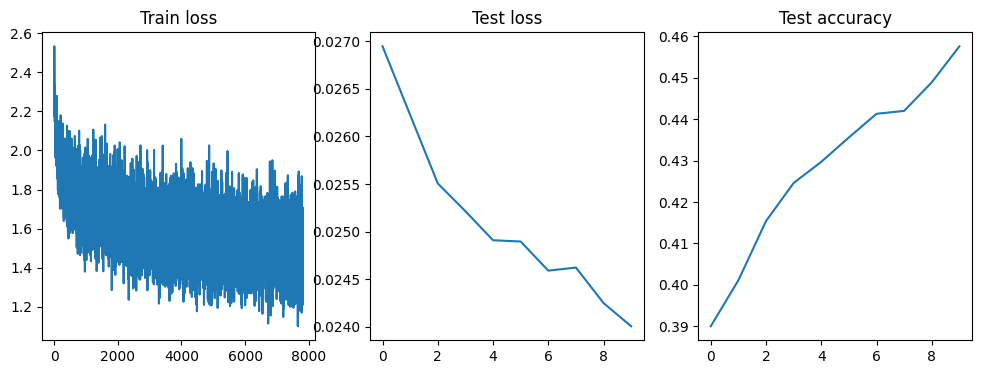

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(stats['train_loss'])
plt.title('Train loss')

plt.subplot(1, 3, 2)
plt.plot(stats['test_loss'])
plt.title('Test loss')

plt.subplot(1, 3, 3)
plt.plot(stats['test_accuracy'])
plt.title('Test accuracy')

plt.show()
